In [4]:
from __future__ import print_function

# Standard modules
import os
import pickle
import numpy as np
import nibabel as nib

# Dipy modules
import dipy.viz.regtools as rt
import dipy.align.imwarp as imwarp
from dipy.align import VerbosityLevels
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import regtransforms

# EPI correction (new) modules
import dipy.correct.gradients as gr
from dipy.correct.splines import CubicSplineField
from dipy.correct.epicor import (OppositeBlips_CC,
                                 OffResonanceFieldEstimator)
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)
floating = np.float64

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
# Load data
data_dir = '/home/omar/data/topup_example/'
up_fname = data_dir + "b0_blipup.nii"
down_fname = data_dir + "b0_blipdown.nii"

up_nib = nib.load(up_fname)
up_affine = up_nib.get_affine()
direction, spacings = imwarp.get_direction_and_spacings(up_affine, 3)
up = up_nib.get_data().squeeze().astype(np.float64)

down_nib = nib.load(down_fname)
down_affine = down_nib.get_affine()
down = down_nib.get_data().squeeze().astype(np.float64)

In [6]:
# Parameters
radius = 4
level_iters = [200, 200, 200, 200, 200, 200, 200, 200, 200]
lambdas = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                   0.5, 0.05, 0.05])*300
fwhm = np.array([8, 6, 4, 3, 3, 2, 1, 0, 0])

pedir_up = np.array((0,1,0), dtype=np.float64)
pedir_down = np.array((0,-1,0), dtype=np.float64)

# Preprocess intensities
up /= up.mean()
down /= down.mean()
max_subsampling = 2
in_shape = np.array(up.shape, dtype=np.int32)
regrid_shape = in_shape + max_subsampling
regrided_spacings = ((in_shape - 1) * spacings) / regrid_shape
factors = regrided_spacings / spacings
regrided_up = np.array(gr.regrid(up, factors, regrid_shape)).astype(np.float64)
regrided_down = np.array(gr.regrid(down, factors, regrid_shape)).astype(np.float64)


# Configure and run orfield estimation
distortion_model = OppositeBlips_CC(radius=radius)
estimator = OffResonanceFieldEstimator(distortion_model, level_iters=level_iters, lambdas=lambdas, fwhm=fwhm)

In [7]:
# Optimize or load results
orfield_coef_fname = 'orfield_coef_ss.p'
if os.path.isfile(orfield_coef_fname):
    coef = pickle.load(open(orfield_coef_fname, 'r'))
    kspacing = np.round(estimator.warp_res[-1]/spacings)
    kspacing = kspacing.astype(np.int32)
    kspacing[kspacing < 1] = 1
    orfield = CubicSplineField(up.shape, kspacing)
    orfield.copy_coefficients(coef)
else:
    orfield = estimator.optimize(regrided_down, pedir_down, regrided_up, pedir_up, regrided_spacings)
    pickle.dump(np.array(orfield.coef), open(orfield_coef_fname, 'w'))

Stage: 1 / 9
('>>>kspacing:', array([6, 6, 6], dtype=int32))
('>>>resampled_sp:', array([ 3.51081731,  3.51081754,  3.44571442]))
('>>>sigma_vox:', array([ 0.96766277,  0.96766271,  0.98594567]))
Creating field
Iter: 1 / 200
Energy: 0.432798. [inf]
Iter: 2 / 200
Energy: 0.427823. [inf]
Iter: 3 / 200
Energy: 0.423051. [inf]
Iter: 4 / 200
Energy: 0.418766. [inf]
Iter: 5 / 200
Energy: 0.414534. [inf]
Iter: 6 / 200
Energy: 0.410397. [inf]
Iter: 7 / 200
Energy: 0.406393. [inf]
Iter: 8 / 200
Energy: 0.402389. [inf]
Iter: 9 / 200
Energy: 0.398311. [inf]
Iter: 10 / 200
Energy: 0.394117. [inf]
Iter: 11 / 200
Energy: 0.389734. [inf]
Iter: 12 / 200
Energy: 0.385465. [0.000857]
Iter: 13 / 200
Energy: 0.380963. [0.000864]
Iter: 14 / 200
Energy: 0.376236. [0.000881]
Iter: 15 / 200
Energy: 0.371404. [0.000905]
Iter: 16 / 200
Energy: 0.367076. [0.000927]
Iter: 17 / 200
Energy: 0.363067. [0.000944]
Iter: 18 / 200
Energy: 0.359128. [0.000955]
Iter: 19 / 200
Energy: 0.355302. [0.000958]
Iter: 20 / 200
En

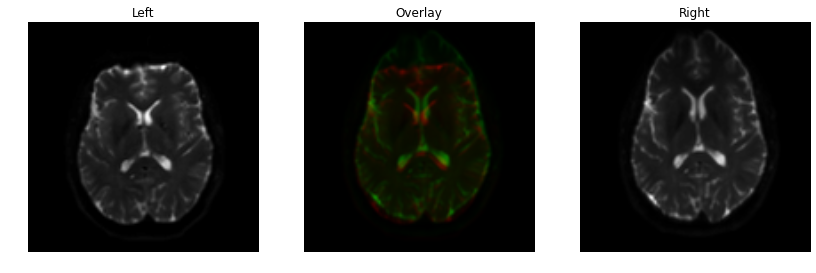

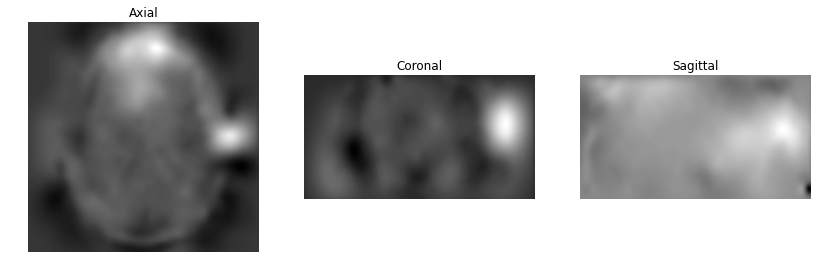

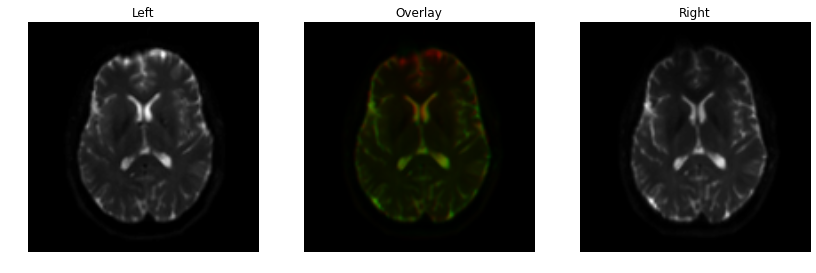

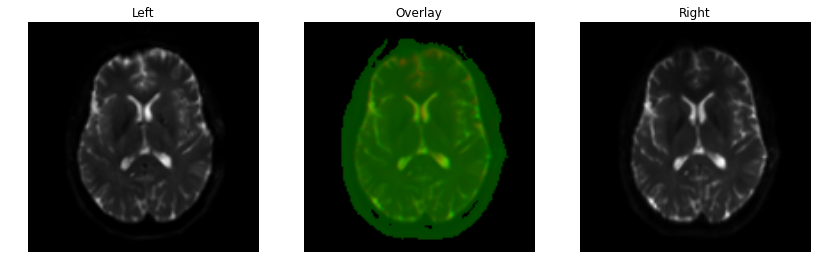

In [11]:
# Warp and modulte images
b  = np.array(orfield.get_volume((0, 0, 0)))
db = np.array(orfield.get_volume((0, 1, 0)))
shape = np.array(regrided_up.shape, dtype=np.int32)
w_up, _m = gr.warp_with_orfield(regrided_up, b, pedir_up, None,
                                None, None, shape)
w_down, _m = gr.warp_with_orfield(regrided_down, b, pedir_down, None,
                                  None, None, shape)
rt.overlay_slices(regrided_down, regrided_up, slice_type=2);
rt.plot_slices(b);
rt.overlay_slices(w_down, w_up, slice_type=2);
rt.overlay_slices(w_down*(1.0-db), w_up*(1+db), slice_type=2);